In [42]:
from typing import Callable
import pickle
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, f_oneway, kruskal, mannwhitneyu

models = [
    "facebook/opt-125m",
    "facebook/opt-350m",
    "facebook/opt-1.3b",
    "facebook/opt-2.7b",
    # "facebook/opt-6.7b",   # Out of memory on 8GB GPU
]

## Analiza statystyczna - ANOVA + post-hoc


?? dla porónania klasyfikacji  w zależności od różnej ilości przykładów w prompcie to do analizy statystycznej tylko F1?

In [43]:
def pairwise_posthoc(
    result_path: str,
    variants: list[str],
    formaterr: Callable[[str], str],
) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(result_path)

    matrix = pd.DataFrame(index=variants, columns=variants, dtype=float)
    medians = pd.DataFrame(index=variants, columns=["median"], dtype=float)

    for a in variants:
        medians.loc[a, "median"] = df[formaterr(a)].median()
        for b in variants:
            if a == b:
                matrix.loc[a, b] = float("nan")
                continue

            arr_a = df[formaterr(a)].dropna().values
            arr_b = df[formaterr(b)].dropna().values

            if len(arr_a) == 0 or len(arr_b) == 0:
                matrix.loc[a, b] = float("nan")
                continue
            _, p = mannwhitneyu(arr_a, arr_b, alternative="two-sided")
            matrix.loc[a, b] = (
                float(p)
            )
    return matrix, medians


In [44]:
def stat_test(result_path: str, variants: list[str], formaterr: Callable[[str], str]) -> None:
    # load data
    df_results = pd.read_csv(result_path)

    # only for F1
    print("Test normalności (Shapiro-Wilk)")
    normality_results = {}

    for var in variants:
        f1_values = df_results[formaterr(var)].values
        stat, p = shapiro(f1_values)
        is_normal = "Normalny" if p > 0.05 else "Nienormalny"
        normality_results[var] = p > 0.05
        print(f"{var}-shot: stat={stat:.6f}, p={p:.6f}, {is_normal}")
    all_normal = all(normality_results.values())

    print("Test porównawczy - ANOVA/Kruskal-Wallis")

    groups = [df_results[formaterr(var)].values for var in variants]

    if all_normal:
        f_stat, p_value = f_oneway(*groups)
        test_name = "ANOVA"
    else:
        f_stat, p_value = kruskal(*groups)
        test_name = "Kruskal-Wallis"

    print(f"Test: {test_name}")
    print(f"Statystyka: {f_stat:.4f}")
    print(f"p-value: {p_value:.8f}")

    if p_value < 0.05:
        print("Istnieje wpływ na F1 (p < 0.05)")
    else:
        print("Brak wpływu na F1 (p >= 0.05)")

    matrix, medians = pairwise_posthoc(result_path, variants, formaterr)

    out_csv = os.path.splitext(result_path)[0] + "_posthoc_matrix.csv"
    matrix.to_csv(out_csv)

    print(matrix)
    print(medians)


print(f"{'n-shots testing':=^50}")
stat_test("../res/shots/results/result_1764951488.csv", [0, 1, 3, 20], lambda var: f"{var}-shots f1")

print(f"{'models size testing':=^50}")
stat_test("../res/models/result_1764949279.csv", models, lambda var: f"{var} f1")

=================n-shots testing==================
Test normalności (Shapiro-Wilk)
0-shot: stat=0.927992, p=0.428439, Normalny
1-shot: stat=0.939991, p=0.552910, Normalny
3-shot: stat=0.922432, p=0.377685, Normalny
20-shot: stat=0.819640, p=0.025090, Nienormalny
Test porównawczy - ANOVA/Kruskal-Wallis
Test: Kruskal-Wallis
Statystyka: 28.6110
p-value: 0.00000270
Istnieje wpływ na F1 (p < 0.05)
          0         1         3         20
0        NaN  0.000182  0.000182  0.000182
1   0.000182       NaN  0.003611  0.011330
3   0.000182  0.003611       NaN  0.121225
20  0.000182  0.011330  0.121225       NaN
      median
0   0.113809
1   0.386361
3   0.473676
20  0.453172
===============models size testing================
Test normalności (Shapiro-Wilk)
facebook/opt-125m-shot: stat=0.764921, p=0.005423, Nienormalny
facebook/opt-350m-shot: stat=0.851873, p=0.061146, Normalny
facebook/opt-1.3b-shot: stat=0.863114, p=0.083031, Normalny
facebook/opt-2.7b-shot: stat=0.900936, p=0.224335, Normaln

Key: 0, Number of confusion matrices: 10


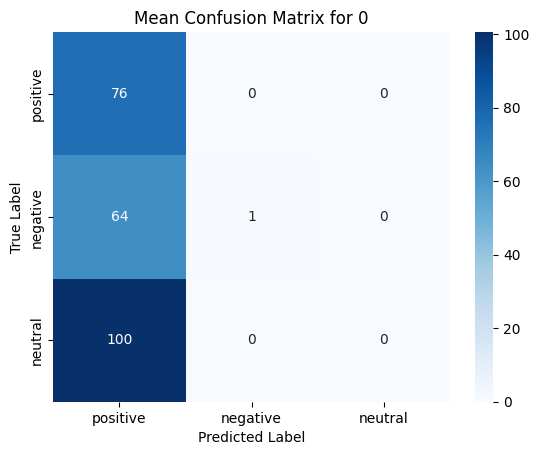

Key: 1, Number of confusion matrices: 10


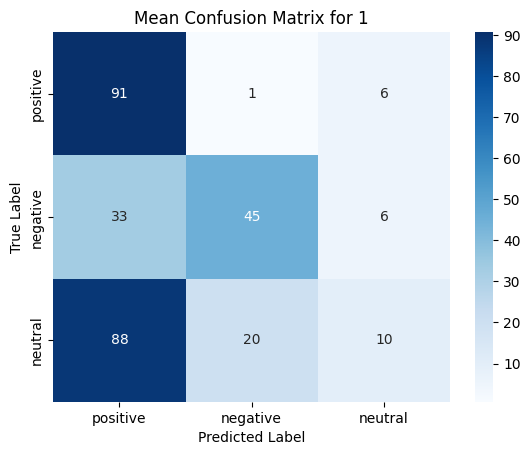

Key: 3, Number of confusion matrices: 10


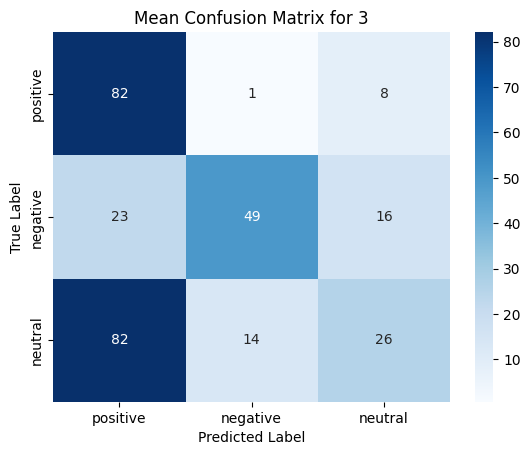

Key: 20, Number of confusion matrices: 10


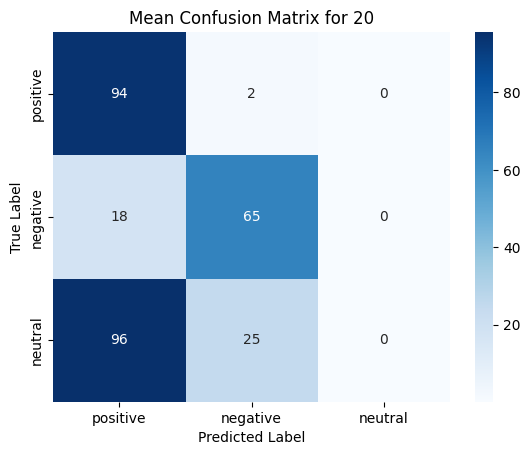

Key: facebook/opt-125m, Number of confusion matrices: 10


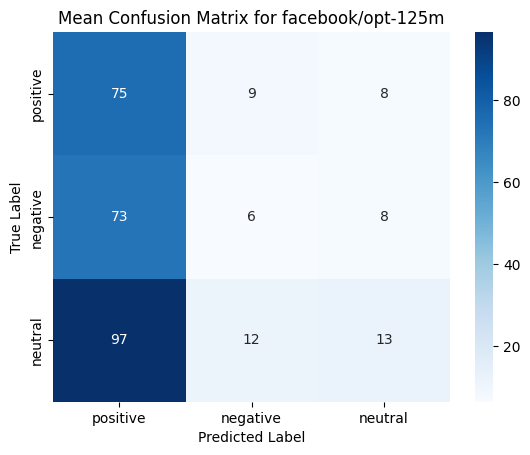

Key: facebook/opt-350m, Number of confusion matrices: 10


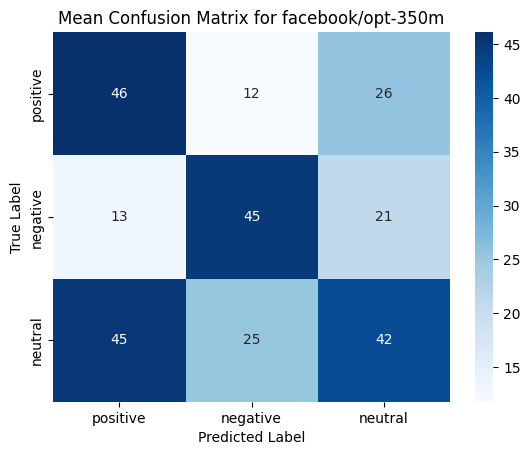

Key: facebook/opt-1.3b, Number of confusion matrices: 10


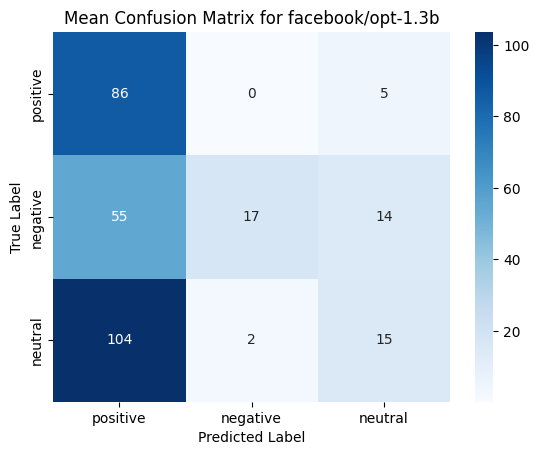

Key: facebook/opt-2.7b, Number of confusion matrices: 10


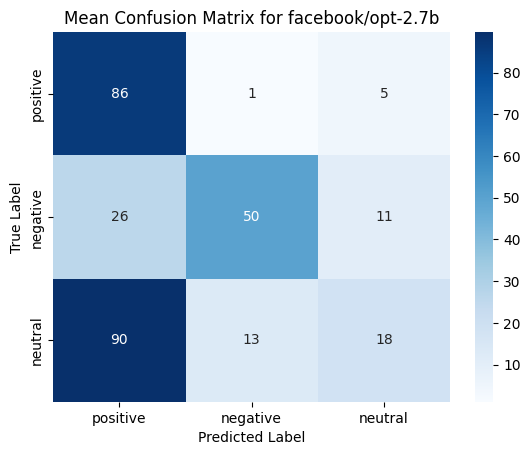

In [45]:
def plot_confusion_matrices(path: str, save_dir: str = None) -> None:
    with open(path, "rb") as f:
        confusion_matrices = pickle.load(f)
    for k, v in confusion_matrices.items():
        print(f"Key: {k}, Number of confusion matrices: {len(v)}")
        mean_arr = np.array(v).mean(axis=0)
        sns.heatmap(
            mean_arr,
            annot=True,
            fmt=".0f",
            cmap="Blues",
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"],
        )

        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.title(f"Mean Confusion Matrix for {k}")

        if save_dir:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(os.path.join(save_dir, f"confusion_matrix_{str(k).replace('/', '_')}.png"))

        plt.show()


plot_confusion_matrices("../res/shots/results/confusion_matrices_ICL_facebook_opt-2.7b_1764952338.pkl", save_dir="../res/shots/results/figs")
plot_confusion_matrices(
    "../res/models/confusion_matrices_ICL_model_size_clf_1764949609.pkl",
    save_dir="../res/models/figs",
)


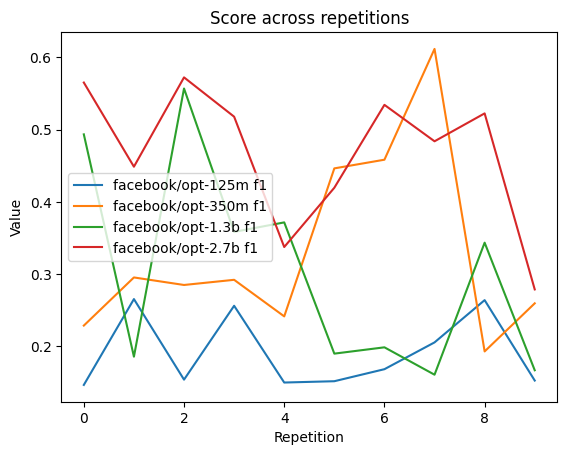

In [59]:
def show_stats(in_path: str, variants: list[str], formaterr: Callable[[str], str]) -> None:
    df_results = pd.read_csv(in_path)

    for var in variants:
        f1_values = df_results[formaterr(var)].values
        plt.plot(f1_values, label=formaterr(var))
        plt.xlabel("Repetition")
        plt.ylabel("Value")
        plt.title("Score across repetitions")
    plt.legend()
    plt.show()


show_stats("../res/models/result_1764949279.csv", models, lambda var: f"{var} f1")

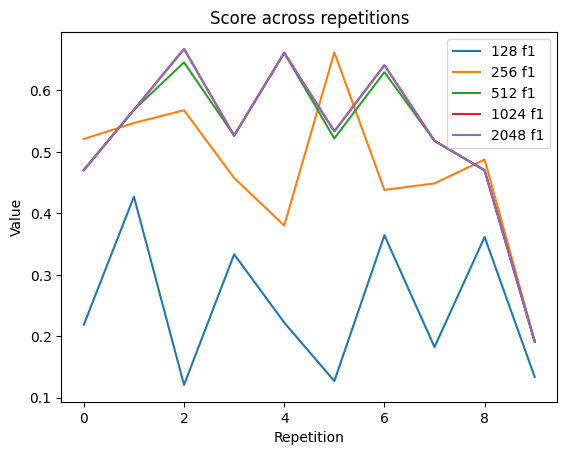

Key: 128, Number of confusion matrices: 10


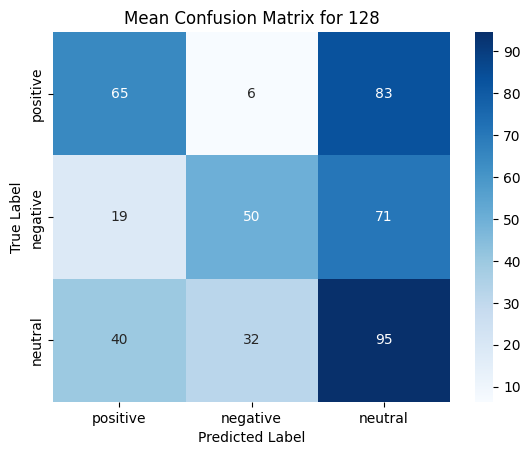

Key: 256, Number of confusion matrices: 10


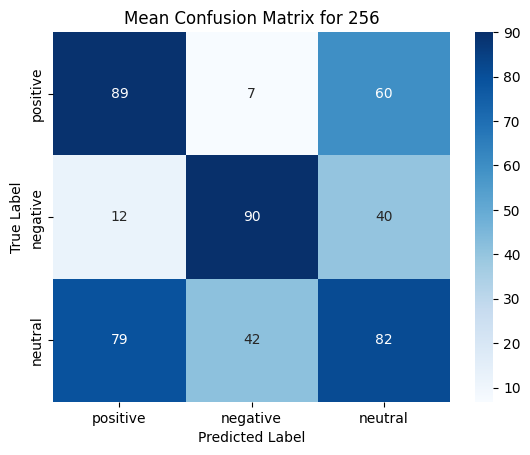

Key: 512, Number of confusion matrices: 10


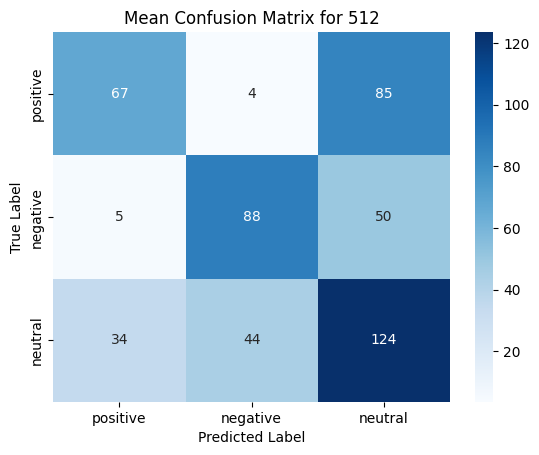

Key: 1024, Number of confusion matrices: 10


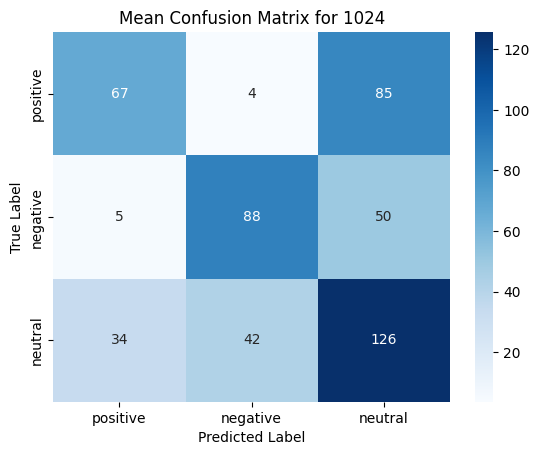

Key: 2048, Number of confusion matrices: 10


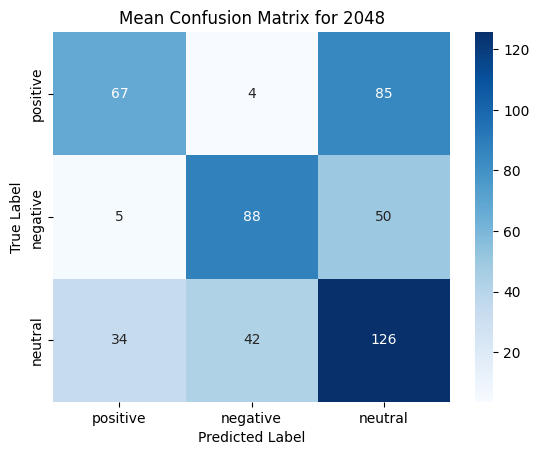

Test normalności (Shapiro-Wilk)
128-shot: stat=0.894074, p=0.188378, Normalny
256-shot: stat=0.935322, p=0.502225, Normalny
512-shot: stat=0.829464, p=0.032967, Nienormalny
1024-shot: stat=0.837255, p=0.040903, Nienormalny
2048-shot: stat=0.837255, p=0.040903, Nienormalny
Test porównawczy - ANOVA/Kruskal-Wallis
Test: Kruskal-Wallis
Statystyka: 19.7016
p-value: 0.00057190
Istnieje wpływ na F1 (p < 0.05)
          128       256       512       1024      2048
128        NaN  0.001315  0.001008  0.001008  0.001008
256   0.001315       NaN  0.241322  0.212294  0.212294
512   0.001008  0.241322       NaN  0.820130  0.820130
1024  0.001008  0.212294  0.820130       NaN  1.000000
2048  0.001008  0.212294  0.820130  1.000000       NaN
        median
128   0.220568
256   0.472717
512   0.524228
1024  0.530008
2048  0.530008
Test: Kruskal-Wallis
Statystyka: 19.7016
p-value: 0.00057190
Istnieje wpływ na F1 (p < 0.05)
          128       256       512       1024      2048
128        NaN  0.001315  

In [62]:
ctx_windows_sizes = [128, 256, 512, 1024, 2048]

show_stats("../res/ctx_windows/result_1764956065.csv", ctx_windows_sizes, lambda var: f"{var} f1")
plot_confusion_matrices(
    "../res/ctx_windows/confusion_matrices_ICL_facebook_opt-2.7b_1764957231.pkl",
    save_dir="../res/ctx_windows/figs",
)
stat_test("../res/ctx_windows/result_1764956065.csv", ctx_windows_sizes, lambda var: f"{var} f1")